# Malaria detection in RBCs  
  
  
Malaria is a deadly, infectious, mosquito-borne disease caused by Plasmodium parasites that are transmitted by the bites of infected female Anopheles mosquitoes. There are five parasites that cause malaria, but two types—P. falciparum and P. vivax—cause the majority of the cases. 
  
There are several methods that can be used for malaria detection and diagnosis. Some methods include polymerase chain reaction (PCR) and rapid diagnostic tests (RDT). These two tests are typically used where high-quality microscopy services are not readily available. According to WHO protocol, diagnosis typically involves intensive examination of the blood smear at 100X magnification. Trained people manually count how many red blood cells contain parasites out of 5,000 cells.  
  
Manual diagnosis of blood smears is an intensive manual process that requires expertise in classifying and counting parasitized and uninfected cells. This process may not scale well, especially in regions where the right expertise is hard to find. 
Deep learning models, or more specifically convolutional neural networks (CNNs), have proven very effective in a wide variety of computer vision tasks. Furthermore, once trained, they are also highly scalable. 
  
Hence, malaria detection could benefit from automation through deep learning.

In [1]:
import os
import warnings
import random
import shutil  
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
warnings.filterwarnings('ignore')

In [2]:
# train-test split
# to be run only once
root_dir = 'cell_images'
class_dirs = ['Parasitized','Uninfected']

train_path = os.path.join('data','train')  
test_path = os.path.join('data','test')

test_ratio = 0.15
random_seed=25
for class_dir in class_dirs:
    # create directories
    os.makedirs(os.path.join(train_path,class_dir))
    os.makedirs(os.path.join(test_path,class_dir))
    # shuffle images
    src = os.path.join(root_dir,class_dir) 
    file_list = os.listdir(src)
    random.shuffle(file_list)
    threshold = int(len(file_list) * (1 - test_ratio))
    train_files, test_files = file_list[0:threshold], file_list[threshold:]
    # append path to file names
    train_files = [os.path.join(src,name) for name in train_files]
    test_files = [os.path.join(src,name) for name in test_files]
    # Copy-pasting images
    for name in train_files:
        shutil.copy(name, os.path.join(train_path,class_dir))
    for name in test_files:
        shutil.copy(name, os.path.join(test_path,class_dir))
    
    print(f'Total {class_dir} images: ', len(file_list))
    print('Training: ', len(train_files))
    print('Testing: ', len(test_files))
    print()

Total Parasitized images:  13780
Training:  11713
Testing:  2067

Total Uninfected images:  13780
Training:  11713
Testing:  2067



In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_path = os.path.join('data','train')  
test_path = os.path.join('data','test')
train_datagen = ImageDataGenerator(rescale=1./255,
                            validation_split=0.1,
                            horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)

In [4]:
train_gen = train_datagen.flow_from_directory(directory=train_path,
                                              target_size=(120,120),
                                              batch_size=32,
                                              shuffle=True,
                                              class_mode='binary',
                                              subset='training')

val_gen = train_datagen.flow_from_directory(directory=train_path,
                                            target_size=(120,120),
                                            batch_size=32, 
                                            shuffle=True,
                                            class_mode='binary',
                                            subset='validation')

test_gen = test_datagen.flow_from_directory(directory=test_path,
                                            target_size=(120,120),
                                            batch_size=32,
                                            shuffle=False,
                                            class_mode='binary')
classes = ['Parasitized','Uninfected']

Found 21082 images belonging to 2 classes.
Found 2342 images belonging to 2 classes.
Found 4134 images belonging to 2 classes.


In [5]:
print(f'No. of pixels in a single image: {120*120*3}')
print(f'No. of training batches: {len(train_gen)}')
print(f'No. of validation batches: {len(val_gen)}')
print(f'No. of testing batches: {len(test_gen)}')

No. of pixels in a single image: 43200
No. of training batches: 659
No. of validation batches: 74
No. of testing batches: 130


In [6]:
train_gen.class_indices

{'Parasitized': 0, 'Uninfected': 1}

Exploring the images

In [7]:
random_seed=30
# To help reduce memory usage
import gc
import time
def cleanup():
    gc.collect()
    time.sleep(10)

Loading infected images: 100%|█████████▉| 13777/13779 [02:30<00:00, 92.18it/s] 

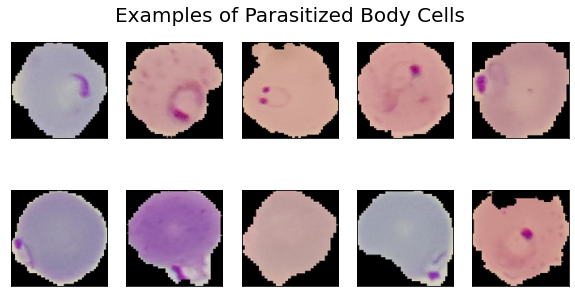

In [8]:
from PIL import Image
from tqdm import tqdm
import os

images_address=os.listdir(os.path.join(root_dir,class_dirs[0]))
images_address.remove('Thumbs.db')
parasitized_data=np.zeros((len(images_address),120,120,3),dtype=np.int16)

bar = tqdm(total=len(images_address), desc='Loading infected images', position=0)
for ind,img_address in enumerate(images_address):
    img=Image.open(os.path.join(root_dir,class_dirs[0],img_address))
    img=img.resize((120,120),Image.ANTIALIAS)
    img=np.asarray(img)
    img=img.astype(np.int16)
    parasitized_data[ind]=img
    bar.update(1)
cleanup()

np.random.seed(random_seed)
random_10=np.random.randint(0,parasitized_data.shape[0],size=10)
fig=plt.figure(figsize=(10,5))
plt.title("Examples of Parasitized Body Cells",fontsize=20)
plt.axis('off')
for ind,rand in enumerate(random_10):
    ax_n=fig.add_subplot(2,5,ind+1)
    ax_n.imshow(parasitized_data[rand])
    ax_n.get_xaxis().set_visible(False)
    ax_n.get_yaxis().set_visible(False)
plt.show()

Loading uninfected images: 100%|█████████▉| 13771/13779 [02:21<00:00, 97.02it/s] 

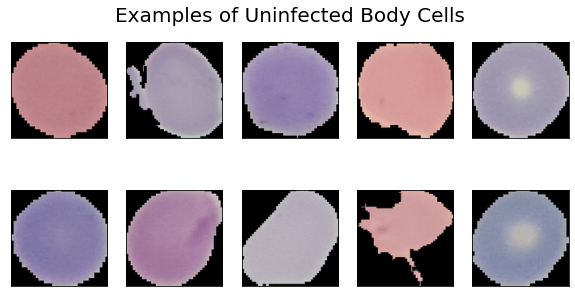

In [9]:
images_address=os.listdir(os.path.join(root_dir,class_dirs[1]))
images_address.remove('Thumbs.db')
uninfected_data=np.zeros((len(images_address),120,120,3),dtype=np.int16)

bar = tqdm(total=len(images_address), desc='Loading uninfected images', position=0)
for ind,img_address in enumerate(images_address):
    img=Image.open(os.path.join(root_dir,class_dirs[1],img_address))
    img=img.resize((120,120),Image.ANTIALIAS)
    img=np.asarray(img)
    img=img.astype(np.int16)
    uninfected_data[ind]=img
    bar.update(1)
cleanup()

np.random.seed(random_seed)
random_10=np.random.randint(0,uninfected_data.shape[0],size=10)
fig=plt.figure(figsize=(10,5))
plt.title("Examples of Uninfected Body Cells",fontsize=20)
plt.axis('off')
for ind,rand in enumerate(random_10):
    ax_n=fig.add_subplot(2,5,ind+1)
    ax_n.imshow(uninfected_data[rand])
    ax_n.get_xaxis().set_visible(False)
    ax_n.get_yaxis().set_visible(False)
plt.show()

In [10]:
# Libraries for CNN
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, Conv2D, MaxPool2D
import logging
tf.get_logger().setLevel(logging.ERROR)

In [11]:
model = Sequential()

# convolution & pooling layers
model.add(Conv2D(16, (3,3), padding='same',activation=tf.nn.relu,input_shape=(120,120,3)))
model.add(MaxPool2D(2,2))

model.add(Conv2D(32, (3,3), padding='same',activation=tf.nn.relu))
model.add(MaxPool2D(2,2))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3,3), padding='same',activation=tf.nn.relu))
model.add(MaxPool2D(2,2))
model.add(Dropout(0.2))

# fully connected layers
model.add(Flatten())
model.add(Dense(128, activation=tf.nn.relu))
model.add(Dense(64, activation=tf.nn.relu))
model.add(Dense(1,activation='sigmoid'))

model.summary()

Loading uninfected images: 100%|██████████| 13779/13779 [02:36<00:00, 97.02it/s]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 120, 120, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 60, 60, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 60, 60, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 15, 15, 64)        0

In [12]:
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [13]:
# training hyperparameters
ACCURACY_THRESHOLD = 0.96
TRAINING_STEPS = len(train_gen)
VALIDATION_STEPS = len(val_gen)
TEST_STEPS = len(test_gen)
EPOCHS = 20

In [14]:
# define callback for early stopping
class myCallback(tf.keras.callbacks.Callback): 
    def on_epoch_end(self, epoch, logs={}): 
        if(logs.get('accuracy') > ACCURACY_THRESHOLD):   
            print("\nReached %2.2f%% accuracy, end training." %(ACCURACY_THRESHOLD*100))   
            self.model.stop_training = True
callbacks = myCallback()

In [15]:
history = model.fit_generator(
    train_gen,
    epochs=20,
    steps_per_epoch=TRAINING_STEPS,
    validation_data=val_gen,
    validation_steps=VALIDATION_STEPS,
    callbacks = [callbacks],
    verbose=1
)

Epoch 1/20
659/659 [==============================] - 1444s 2s/step - loss: 0.5008 - accuracy: 0.7371 - val_loss: 0.4967 - val_accuracy: 0.8190
Epoch 2/20
659/659 [==============================] - 1006s 2s/step - loss: 0.1977 - accuracy: 0.9327 - val_loss: 0.2145 - val_accuracy: 0.9078
Epoch 3/20
659/659 [==============================] - 941s 1s/step - loss: 0.1585 - accuracy: 0.9480 - val_loss: 0.2286 - val_accuracy: 0.9146
Epoch 4/20
659/659 [==============================] - 892s 1s/step - loss: 0.1361 - accuracy: 0.9581 - val_loss: 0.2123 - val_accuracy: 0.9184
Epoch 5/20
659/659 [==============================] - 1046s 2s/step - loss: 0.1251 - accuracy: 0.9600 - val_loss: 0.2394 - val_accuracy: 0.9184
Epoch 6/20
659/659 [==============================] - ETA: 0s - loss: 0.1187 - accuracy: 0.9619
Reached 96.00% accuracy, end training.
659/659 [==============================] - 1134s 2s/step - loss: 0.1187 - accuracy: 0.9619 - val_loss: 0.2074 - val_accuracy: 0.9261


In [16]:
def plotLearningCurve(history,epochs):
    fig, ax = plt.subplots(1, 2, figsize=(10,5))
    epochRange = range(1,epochs+1)
    
    ax[0].set_title('Accuracy per Epoch')
    sns.lineplot(x=epochRange, y=history.history['accuracy'], marker='o',ax=ax[0])
    sns.lineplot(x=epochRange, y=history.history['val_accuracy'], marker='o',ax=ax[0])
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Accuracy')
    ax[0].legend(['training','validation'])
    
    ax[1].set_title('Loss per Epoch')
    sns.lineplot(x=epochRange, y=history.history['loss'], marker='o',ax=ax[1])
    sns.lineplot(x=epochRange, y=history.history['val_loss'], marker='o',ax=ax[1])
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Loss')
    ax[1].legend(['training','validation'])
    plt.show()

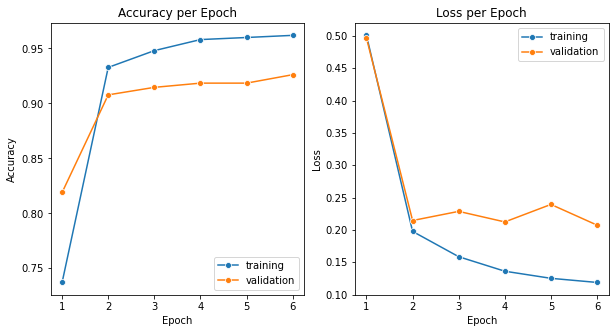

In [17]:
plotLearningCurve(history,len(history.history['loss']))

In [18]:
test_gen.reset()
res = model.evaluate(
    x=test_gen,
    verbose=1,
    steps=TEST_STEPS
)

130/130 [==============================] - 110s 844ms/step - loss: 0.1474 - accuracy: 0.9543


In [19]:
print('Model Loss on test set: {loss:.4f}'.format(loss = res[0]))
print('Model Accuracy on test set: {accuracy:.4f}'.format(accuracy = res[1]))

Model Loss on test set: 0.1474
Model Accuracy on test set: 0.9543


In [20]:
# Setting up the data for the confusion matrix
from sklearn.metrics import confusion_matrix 
import itertools 
test_gen.reset()
preds = (model.predict(x=test_gen, verbose=1, steps=TEST_STEPS) > 0.5).astype("int32")
true = test_gen.classes
cm = confusion_matrix(y_true=true, y_pred=preds)

130/130 [==============================] - 54s 416ms/step


In [21]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.winter):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label');

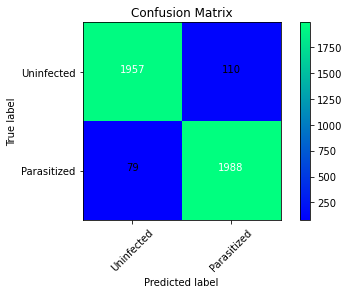

In [22]:
cm_plot_labels= ["Uninfected","Parasitized"]
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title="Confusion Matrix");

In [23]:
# Saving the model
model.save('Malaria_CNN')